In [2]:
# ------------------  set up logging ----------------------
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging()

import os
from scipy import stats
from scipy.stats import mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
from auditory_cortex.neural_data import NormalizerCalculator
from auditory_cortex.neural_data import create_neural_metadata, create_neural_dataset
from auditory_cortex import results_dir
from auditory_cortex.plotters.plotter_utils import PlotterUtils

In [3]:
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)
sessions = metadata.get_all_available_sessions()
norm_obj = NormalizerCalculator(dataset_name)

In [6]:
bin_width = 50
mVocs = True
p_value = 0.05
tuned_channels = []
all_p_values = []
highly_tuned_channels = []
session_null_dist = {}
session_norm_dist = {}
for session in sessions:
    shifted_null = norm_obj.get_normalizer_null_dist_using_random_shifts(
        session, bin_width=bin_width, mVocs=mVocs, force_redo=False
    )
    norm_dist = norm_obj.get_normalizer_for_session(
        session, bin_width=bin_width, mVocs=mVocs
    ) 
    session_null_dist[session] = shifted_null
    session_norm_dist[session] = norm_dist

INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180413, bw-50, mVocs=True
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180420, bw-50, mVocs=True
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180501, bw-50, mVocs=True
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180502, bw-50, mVocs=True
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180613, bw-50, mVocs=True
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180622, bw-50, mVocs=True
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180627, bw-50, mVocs=True
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180717, bw-50, mVocs=True
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. 

### mean vs medians - all channels

result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/normalizers-mean-median-all-mVocs.tex


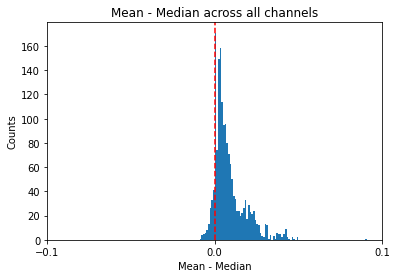

In [7]:
sess_wise_means = {}
sess_wise_medians = {}
sess_wise_stds = {}
num_samples = {}
all_differences = []
for session in sessions:
    sess_norm_dist =  session_norm_dist[session]
    mean = np.mean(sess_norm_dist, axis=0)
    median = np.median(sess_norm_dist, axis=0)
    diff = mean - median
    all_differences.extend(diff)
    sess_wise_means[session] = mean
    sess_wise_medians[session] = median
    sess_wise_stds[session] = np.std(sess_norm_dist, axis=0)
    num_samples[session] = sess_norm_dist.shape[0]

plt.hist(all_differences, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlim(-0.1, 0.1)
plt.xticks([-0.1, 0, 0.1],)
plt.xlabel('Mean - Median')
plt.ylabel('Counts')
plt.title('Mean - Median across all channels')

if mVocs:
    stim = 'mVocs'
else:
    stim = 'timit'
filepath = os.path.join(
    results_dir,
    'tikz_plots',
    f"normalizers-mean-median-all-{stim}.tex"
    )
PlotterUtils.save_tikz(filepath)


### tuned-channels

In [34]:
p_value = 0.05
all_p_values = []
session_wise_tuned_channels = {}
for session in sessions:    
    shifted_null = session_null_dist[session]
    norm_dist = session_norm_dist[session]
    tuned_channels = []
    for ch in range(shifted_null.shape[1]):
        dist1 = norm_dist[:,ch]
        dist2 = shifted_null[:,ch]
        stat, p = mannwhitneyu(dist1, dist2, alternative='greater')  # dist1 > dist2
        all_p_values.append(p)
        if p < p_value:
            tuned_channels.append(ch)
    session_wise_tuned_channels[session] = tuned_channels
all_p_values = np.array(all_p_values)  

In [35]:
tuned_means = []
tuned_medians = []
for sess in sessions:
    if sess in session_wise_tuned_channels.keys():
        ch_ids = np.array(session_wise_tuned_channels[sess])
        if len(ch_ids) == 0:
            continue
        mean = sess_wise_means[sess][ch_ids]
        median = sess_wise_medians[sess][ch_ids]

        tuned_means.extend(mean)
        tuned_medians.extend(median)
tuned_differences = np.array(tuned_means) - np.array(tuned_medians)

result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/normalizers-mean-median-tuned-timit.tex


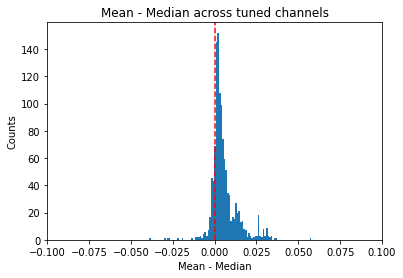

In [36]:
plt.hist(tuned_differences, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlim(-0.1, 0.1)
plt.xlabel('Mean - Median')
plt.ylabel('Counts')
plt.title('Mean - Median across tuned channels')

if mVocs:
    stim = 'mVocs'
else:
    stim = 'timit'
filepath = os.path.join(
    results_dir,
    'tikz_plots',
    f"normalizers-mean-median-tuned-{stim}.tex"
    )
PlotterUtils.save_tikz(filepath)

### highly-tuned

In [37]:
tuned_channels = []
all_p_values = []
highly_tuned_channels = []

std_deviations_away = [0.1, 0.3, 1.0]
total_highly_tuned = {s:0 for s in std_deviations_away}
total_highly_tuned_medians = {s:0 for s in std_deviations_away}
highly_tuned_sess_channels = {s:{} for s in std_deviations_away}
for session in sessions:
    norm_dist = session_norm_dist[session]
    shifted_null = session_null_dist[session]

    norm_means = np.mean(norm_dist, axis=0)
    null_means = np.mean(shifted_null, axis=0)

    norm_medians = np.median(norm_dist, axis=0)
    null_medians = np.median(shifted_null, axis=0)

    null_std = np.std(shifted_null, axis=0)

    for s in std_deviations_away:
        thresh = null_means + (s * null_std)
        highly_tuned = np.where(norm_means > thresh)[0]
        total_highly_tuned[s] += len(highly_tuned)
        highly_tuned_sess_channels[s][session] = highly_tuned

        thresh = null_medians + (s * null_std)
        highly_tuned = np.where(norm_medians > thresh)[0]
        total_highly_tuned_medians[s] += len(highly_tuned)


result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/normalizers-mean-median-highly-tuned-gap-0.3-timit.tex


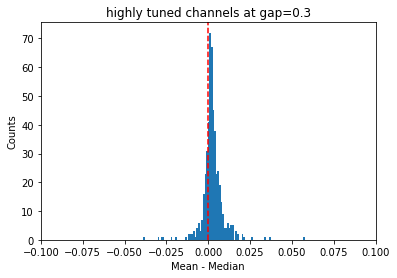

In [38]:
gap = 0.3
highly_tuned_means = []
highly_tuned_medians = []
sess_wise_highly_tuned = highly_tuned_sess_channels[gap]
for sess in sessions:
    if sess in sess_wise_highly_tuned.keys():
        ch_ids = np.array(sess_wise_highly_tuned[sess])
        mean = sess_wise_means[sess][ch_ids]
        median = sess_wise_medians[sess][ch_ids]

        highly_tuned_means.extend(mean)
        highly_tuned_medians.extend(median)
highly_tuned_differences = np.array(highly_tuned_means) - np.array(highly_tuned_medians)
# plotting...
plt.hist(highly_tuned_differences, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlim(-0.1, 0.1)
plt.xlabel('Mean - Median')
plt.ylabel('Counts')
plt.title(f'highly tuned channels at gap={gap}')

if mVocs:
    stim = 'mVocs'
else:
    stim = 'timit'
filepath = os.path.join(
    results_dir,
    'tikz_plots',
    f"normalizers-mean-median-highly-tuned-gap-{gap}-{stim}.tex"
    )
PlotterUtils.save_tikz(filepath)

result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/normalizers-mean-median-highly-tuned-gap-1.0-timit.tex


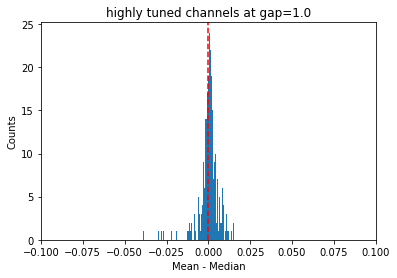

In [39]:
gap = 1.0
highly_tuned_means = []
highly_tuned_medians = []
sess_wise_highly_tuned = highly_tuned_sess_channels[gap]
for sess in sessions:
    if sess in sess_wise_highly_tuned.keys():
        ch_ids = np.array(sess_wise_highly_tuned[sess])
        mean = sess_wise_means[sess][ch_ids]
        median = sess_wise_medians[sess][ch_ids]

        highly_tuned_means.extend(mean)
        highly_tuned_medians.extend(median)
highly_tuned_differences = np.array(highly_tuned_means) - np.array(highly_tuned_medians)
# plotting...
plt.hist(highly_tuned_differences, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlim(-0.1, 0.1)
plt.xlabel('Mean - Median')
plt.ylabel('Counts')
plt.title(f'highly tuned channels at gap={gap}')

if mVocs:
    stim = 'mVocs'
else:
    stim = 'timit'
filepath = os.path.join(
    results_dir,
    'tikz_plots',
    f"normalizers-mean-median-highly-tuned-gap-{gap}-{stim}.tex"
    )
PlotterUtils.save_tikz(filepath)